# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [ ]:
#@title some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]

def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test

def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5, train=True):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """

    # train the model
    if train:
      history=model.fit(X_train, y_train,
                        validation_split= 0.1,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    if train:
      fig, axs = plt.subplots(1,2, figsize=(12,5))
      # summarize history for loss
      axs[0].plot(history.history['loss'])
      axs[0].plot(history.history['val_loss'])
      axs[0].set_title(model.name+' loss')
      axs[0].set_ylabel('loss')
      axs[0].set_xlabel('epoch')
      axs[0].legend(['train', 'val'], loc='upper left')

      # summarize history for accuracy
      axs[1].plot(history.history['accuracy'])
      axs[1].plot(history.history['val_accuracy'])
      axs[1].set_title(model.name+' accuracy')
      axs[1].set_ylabel('accuracy')
      axs[1].set_xlabel('epoch')
      axs[1].legend(['train', 'val'], loc='upper left')
      plt.show()

def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

# attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers.
    # Input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence.
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder.
    # Encoder_outputs are all the states.
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # Create the context vector by applying attention to concatenate the input + context vectore to find the next decoder's input.
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM.
        # Run the decoder on one timestep with attended input and previous states.
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output.
        # Save the current prediction.
        # We will concatenate all predictions later.
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration as well as update the states.
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, encoder_lstm, decoder_lstm, decoder_dense

class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# dataset
n_timesteps_in = 100  # sequence length
n_features = 20       # maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 169s 2s/step - loss: 2.9659 - accuracy: 0.0542 - val_loss: 2.9479 - val_accuracy: 0.0557
Epoch 2/200
18/18 [==============================] - 5s 263ms/step - loss: 2.9456 - accuracy: 0.0561 - val_loss: 2.9450 - val_accuracy: 0.0568
Epoch 3/200
18/18 [==============================] - 5s 261ms/step - loss: 2.9417 - accuracy: 0.0624 - val_loss: 2.9514 - val_accuracy: 0.0628
Epoch 4/200
18/18 [==============================] - 5s 261ms/step - loss: 2.9385 - accuracy: 0.0673 - val_loss: 2.9332 - val_accuracy: 0.0714
Epoch 5/200
18/18 [==============================] - 5s 265ms/step - loss: 2.9307 - accuracy: 0.0749 - val_loss: 2.9267 - val_accuracy: 0.0750
Epoch 6/200
18/18 [==============================] - 5s 261ms/step - loss: 2.9213 - accuracy: 0.0801 - val_loss: 2.9156 - val_accuracy: 0.0815
Epoch 7/200
18/18 [==============================] - 5s 262ms/step - loss: 2.9132 - accuracy: 0.0840 - val_loss: 2.9072 - val_accuracy: 0.0877


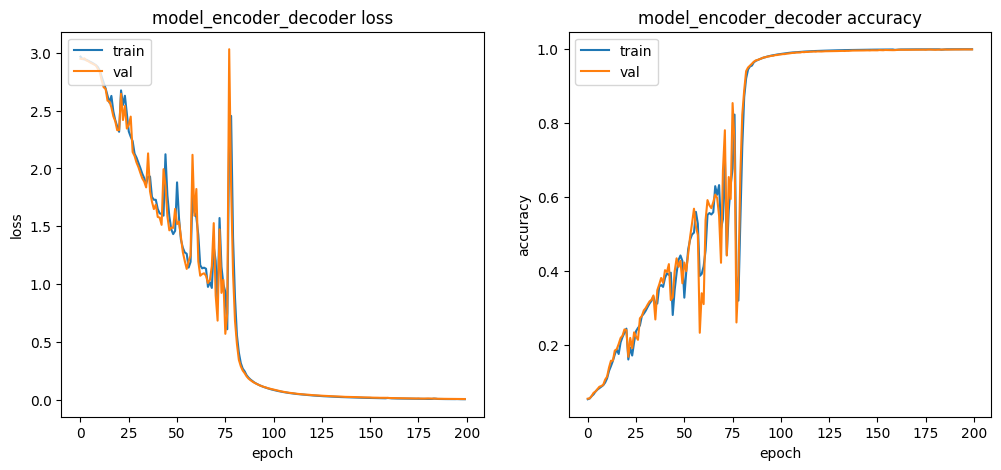

In [ ]:
# training
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40) # patience as 10-20% of epochs

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden_size)
        # values shape == (batch_size, max_length, hidden_size)

        # expand the dimensions of query to perform addition
        query_with_time_axis = tf.expand_dims(query, 1)

        # score calculation using attention model
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W = tf.keras.layers.Dense(units)

    def call(self, query, values):
        # query shape == (batch_size, hidden_size)
        # values shape == (batch_size, max_length, hidden_size)

        # project query to the same dimension as values
        query_with_time_axis = self.W(query)

        # score calculation using dot product
        score = tf.matmul(values, query_with_time_axis, transpose_b=True)

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Comparative Training

Epoch 1/200
18/18 [==============================] - 165s 2s/step - loss: 2.9651 - accuracy: 0.0529 - val_loss: 2.9477 - val_accuracy: 0.0531
Epoch 2/200
18/18 [==============================] - 5s 262ms/step - loss: 2.9452 - accuracy: 0.0564 - val_loss: 2.9430 - val_accuracy: 0.0636
Epoch 3/200
18/18 [==============================] - 5s 253ms/step - loss: 2.9421 - accuracy: 0.0603 - val_loss: 2.9423 - val_accuracy: 0.0611
Epoch 4/200
18/18 [==============================] - 5s 260ms/step - loss: 2.9425 - accuracy: 0.0648 - val_loss: 2.9410 - val_accuracy: 0.0762
Epoch 5/200
18/18 [==============================] - 5s 262ms/step - loss: 2.9371 - accuracy: 0.0717 - val_loss: 2.9301 - val_accuracy: 0.0723
Epoch 6/200
18/18 [==============================] - 5s 261ms/step - loss: 2.9275 - accuracy: 0.0748 - val_loss: 2.9229 - val_accuracy: 0.0777
Epoch 7/200
18/18 [==============================] - 5s 255ms/step - loss: 2.9168 - accuracy: 0.0828 - val_loss: 2.9106 - val_accuracy: 0.0868


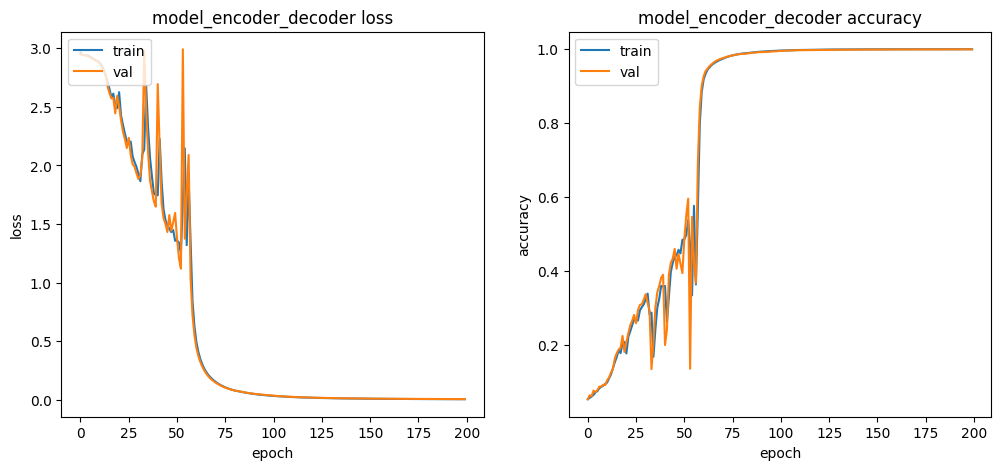

In [ ]:
attention_LDA = LuongDotAttention()
model_attention_LDA, encoder_lstm_LDA, decoder_lstm_LDA, decoder_dense_LDA = build_attention_model(attention_LDA, batch_size, rnn_units)
train_test(model_attention_LDA, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

Epoch 1/200
18/18 [==============================] - 192s 3s/step - loss: 2.9665 - accuracy: 0.0531 - val_loss: 2.9478 - val_accuracy: 0.0533
Epoch 2/200
18/18 [==============================] - 14s 765ms/step - loss: 2.9462 - accuracy: 0.0555 - val_loss: 2.9441 - val_accuracy: 0.0587
Epoch 3/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9419 - accuracy: 0.0615 - val_loss: 2.9380 - val_accuracy: 0.0668
Epoch 4/200
18/18 [==============================] - 14s 768ms/step - loss: 2.9382 - accuracy: 0.0667 - val_loss: 2.9367 - val_accuracy: 0.0632
Epoch 5/200
18/18 [==============================] - 14s 767ms/step - loss: 2.9320 - accuracy: 0.0725 - val_loss: 2.9245 - val_accuracy: 0.0759
Epoch 6/200
18/18 [==============================] - 14s 761ms/step - loss: 2.9250 - accuracy: 0.0776 - val_loss: 2.9201 - val_accuracy: 0.0775
Epoch 7/200
18/18 [==============================] - 14s 769ms/step - loss: 2.9139 - accuracy: 0.0833 - val_loss: 2.9101 - val_accuracy: 0

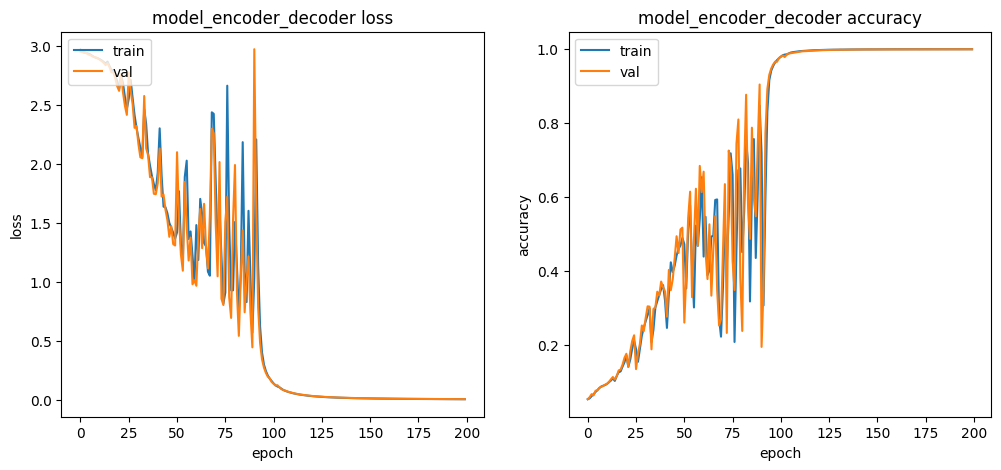

In [ ]:
attention_BA = BahdanauAttention(rnn_units)
model_attention_BA, encoder_lstm_BA, decoder_lstm_BA, decoder_dense_BA = build_attention_model(attention_BA, batch_size, rnn_units)
train_test(model_attention_BA, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

Epoch 1/200
18/18 [==============================] - 178s 3s/step - loss: 2.9636 - accuracy: 0.0525 - val_loss: 2.9467 - val_accuracy: 0.0524
Epoch 2/200
18/18 [==============================] - 15s 829ms/step - loss: 2.9461 - accuracy: 0.0537 - val_loss: 2.9460 - val_accuracy: 0.0520
Epoch 3/200
18/18 [==============================] - 15s 833ms/step - loss: 2.9441 - accuracy: 0.0578 - val_loss: 2.9429 - val_accuracy: 0.0595
Epoch 4/200
18/18 [==============================] - 15s 831ms/step - loss: 2.9437 - accuracy: 0.0574 - val_loss: 2.9432 - val_accuracy: 0.0604
Epoch 5/200
18/18 [==============================] - 15s 832ms/step - loss: 2.9410 - accuracy: 0.0636 - val_loss: 2.9385 - val_accuracy: 0.0698
Epoch 6/200
18/18 [==============================] - 15s 830ms/step - loss: 2.9347 - accuracy: 0.0695 - val_loss: 2.9321 - val_accuracy: 0.0730
Epoch 7/200
18/18 [==============================] - 15s 830ms/step - loss: 2.9245 - accuracy: 0.0775 - val_loss: 2.9190 - val_accuracy: 0

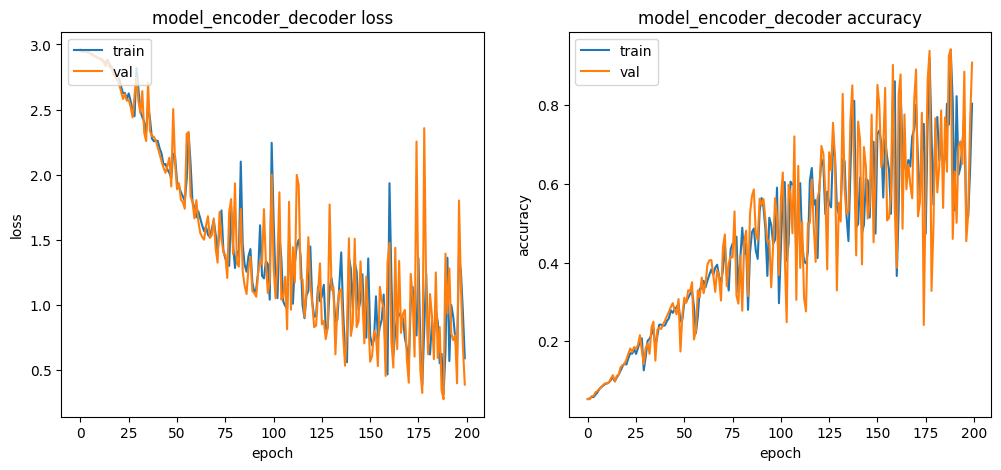

In [ ]:
attention_LGA = LuongGeneralAttention(rnn_units)
model_attention_LGA, encoder_lstm_LGA, decoder_lstm_LGA, decoder_dense_LGA = build_attention_model(attention_LGA, batch_size, rnn_units)
train_test(model_attention_LGA, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

## Visualization

In [ ]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  # same loop as in build_attention_model
  for t in range(n_timesteps_in):
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      inputs = tf.concat([context_vector, inputs], axis=-1)

      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])

  return seq_in, seq_out, attention_plot

In [ ]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

<ipython-input-8-851cc129706d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
<ipython-input-8-851cc129706d>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)


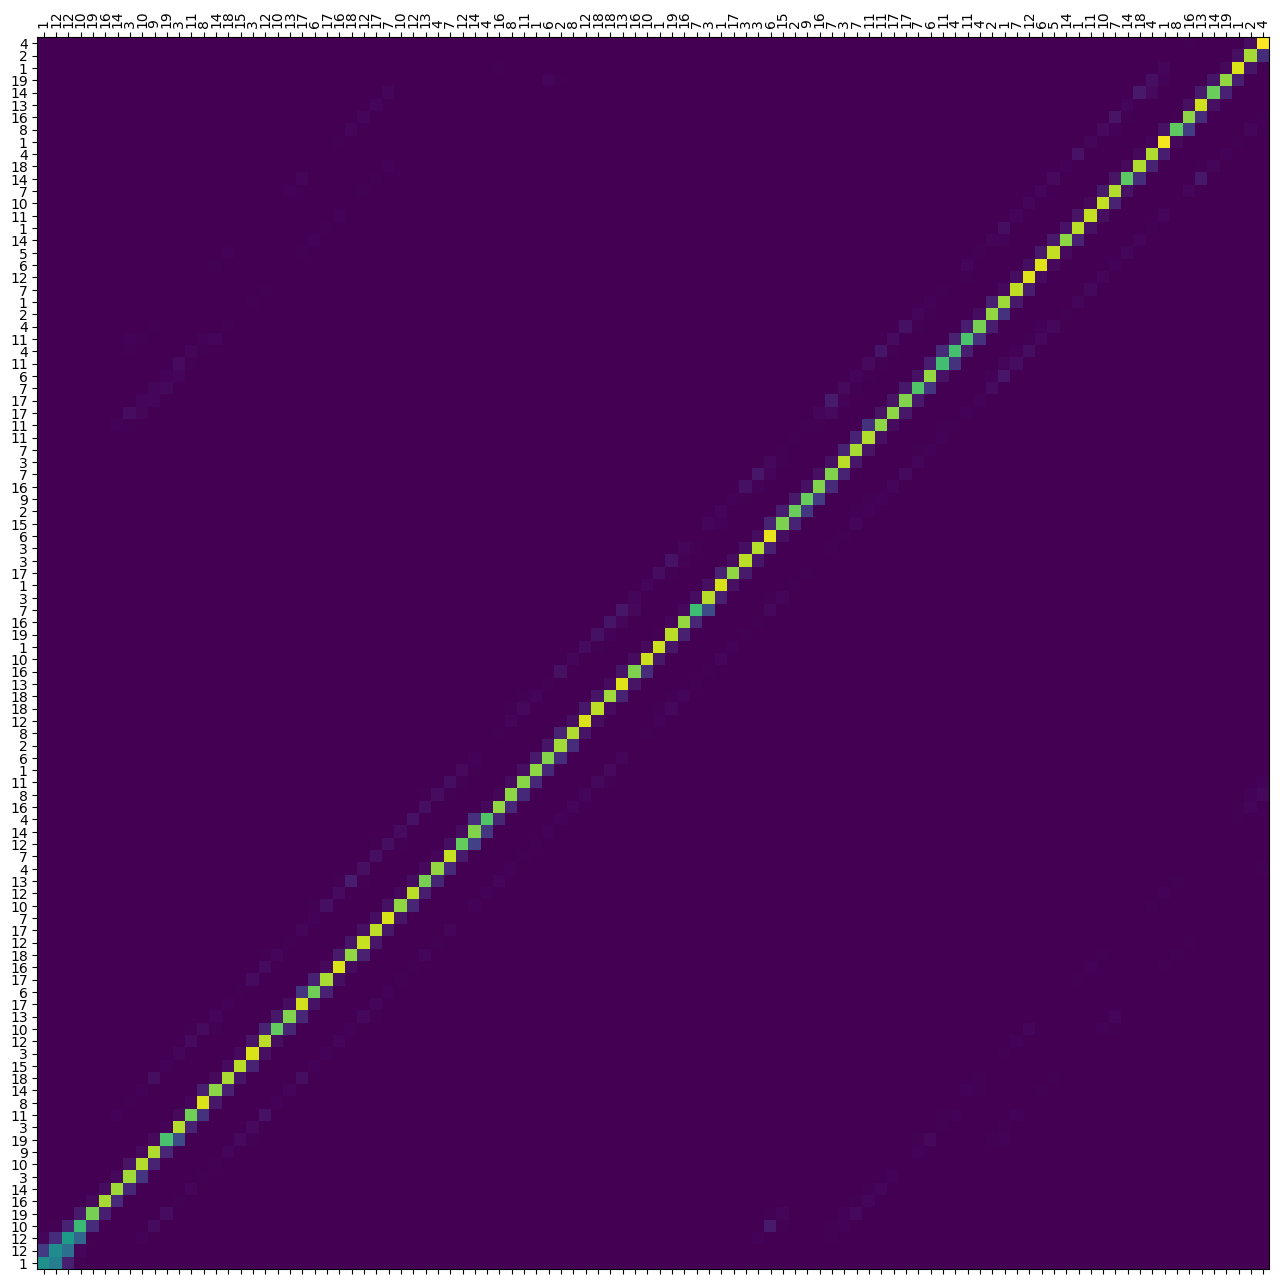

In [ ]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_LDA, decoder_lstm_LDA, decoder_dense_LDA, attention_LDA)

Note that the diagonal is inverted due to the ordering of the axes. The visualization for BA will look similar, while the LGA will show convergence but not look entirely similar as it needs more epochs to converge to the same weight matrix.

# Comparison




Unfortunately, the LuongGeneralAttention needs more epochs to converge to the same accuracy as the other methods. However, as I have already maxed teh GPU on one google account I could not increase the epochs any further and run enough times to achieve a desirable accuracy.

LuongDotAttention was retrained with the same parameters as the two newly implemented methods.

Looking at LuongDotAttention and BahnadauAttention, both take all 200 epochs to converge and acheive the same testing accuracy.

LGA could have also acheieved this with more epochs I believe.